# Variogram Point Cloud - tutorial

## Table of Contents:

1. Read point data,
2. Set proper lag size with variogram cloud histogram,
3. Detect and remove outliers.
4. Calculate experimental semivariance from point cloud.

## Level: Basic

## Changelog

| Date | Change description | Author |
|------|--------------------|--------|
| 2021-05-11 | Refactored TheoreticalSemivariogram class | @szymon-datalions |
| 2021-03-31 | Update related to the change of semivariogram weighting. Updated cancer rates data. | @szymon-datalions |

## Introduction

In this tutorial we will learn how to read and prepare data for semivariogram modeling, how to manually find the best step size between lags and how to detect outliers in our data which can affect final semivariogram.

Variogram Point Cloud analysis is an additional, basic data preparation step which may save you a lot of headache with more sophisticated analysis. You should learn about Variogram Point Cloud analysis before you move on to the semivariogram estimation and semivariogram fitting operations.

We use: 

- for point 1 and 2: DEM data which is stored in a file `sample_data/point_data/poland_dem_gorzow_wielkopolski`,
- for point 3: Breast cancer rates data is stored in the shapefile in folder `sample_data/areal_data/breast_cancer_rate_per_area_2.shp`.

## Import packages

In [1]:
import numpy as np
from collections import OrderedDict

import matplotlib.pyplot as plt

from pyinterpolate.io_ops import read_point_data
from pyinterpolate.io_ops import prepare_areal_shapefile, get_points_within_area
from pyinterpolate.distance.calculate_distances import calc_point_to_point_distance  # We need this to find max distance between points
from pyinterpolate.semivariance import build_variogram_point_cloud, show_variogram_cloud, remove_outliers
from pyinterpolate.semivariance import calculate_semivariance, calc_semivariance_from_pt_cloud

## 1) Read point data

In [2]:
dem = read_point_data('../sample_data/point_data/poland_dem_gorzow_wielkopolski', data_type='txt')

In [3]:
# Look into a first few lines of data

dem[:10, :]

array([[15.1152409 , 52.76514556, 91.27559662],
       [15.1152409 , 52.74279035, 96.54829407],
       [15.1152409 , 52.71070647, 51.25455093],
       [15.1152409 , 52.70884354, 48.95828247],
       [15.1152409 , 52.67137785, 16.81786346],
       [15.1152409 , 52.6498506 , 16.29390526],
       [15.1152409 , 52.62770238, 16.54066277],
       [15.1152409 , 52.60596814, 19.45093346],
       [15.1152409 , 52.60493317, 19.24267578],
       [15.1152409 , 52.57823111, 45.66201019]])

## 2) Set proper lag size with variogram cloud histogram

In this step we generate Variogram Point Cloud. For each proposed lag algorithm assigns point's values which are grouped in this lag. We check and compare few different lags and step sizes and their respective point clouds.

In [4]:
# Create analysis parameters

# Check max distance between points
distances = calc_point_to_point_distance(dem[:, :-1])
maximum_range = np.max(distances)

number_of_lags = [4, 8, 16, 32]
step_sizes = [maximum_range / x for x in number_of_lags]

variogram_clouds = []

for step_size in step_sizes:
    variogram_cloud = build_variogram_point_cloud(dem, step_size, maximum_range)
    variogram_clouds.append(variogram_cloud)

Now we check how many points are grouped for each lag:

In [5]:
for idx, lag in enumerate(number_of_lags):
    print(f'Lags per area: {lag}')
    print('')
    var_cloud = variogram_clouds[idx]
    for jdx, cloud in enumerate(var_cloud.keys()):
        l = len(var_cloud[cloud])
        print(f'Lag {cloud} has {l} points.')
    
    print('\n###########\n')    

Lags per area: 4

Lag 0.0 has 3949909 points.
Lag 0.08380184447417775 has 20797686 points.
Lag 0.1676036889483555 has 18499412 points.
Lag 0.25140553342253324 has 4247496 points.

###########

Lags per area: 8

Lag 0.0 has 1079563 points.
Lag 0.041900922237088876 has 7088626 points.
Lag 0.08380184447417775 has 10807462 points.
Lag 0.12570276671126662 has 11367804 points.
Lag 0.1676036889483555 has 9508578 points.
Lag 0.2095046111854444 has 5675518 points.
Lag 0.25140553342253324 has 1784288 points.
Lag 0.29330645565962216 has 225814 points.

###########

Lags per area: 16

Lag 0.0 has 289011 points.
Lag 0.020950461118544438 has 2030532 points.
Lag 0.041900922237088876 has 3599738 points.
Lag 0.06285138335563331 has 4740508 points.
Lag 0.08380184447417775 has 5457110 points.
Lag 0.1047523055927222 has 5745202 points.
Lag 0.12570276671126662 has 5724576 points.
Lag 0.14665322782981108 has 5401064 points.
Lag 0.1676036889483555 has 4788456 points.
Lag 0.18855415006689993 has 3905638 point

### Clarification:

Raw numbers are hard to analyze. But we can check those informations with boxplots and that we can learn more about the data:

Lags per area: 4



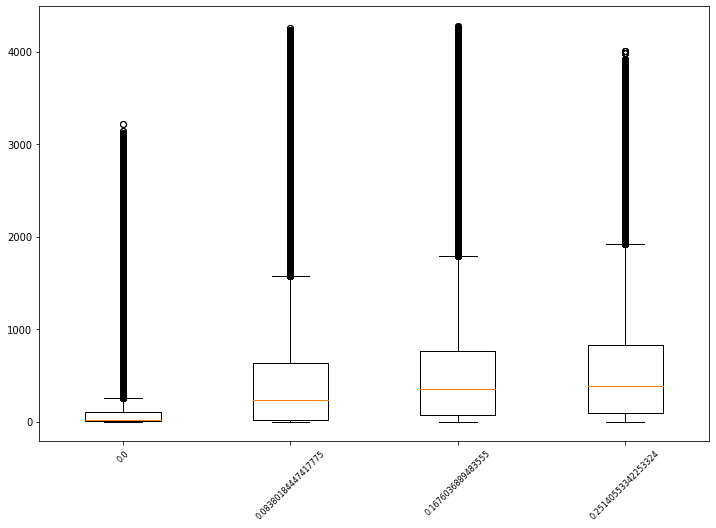


###########

Lags per area: 8



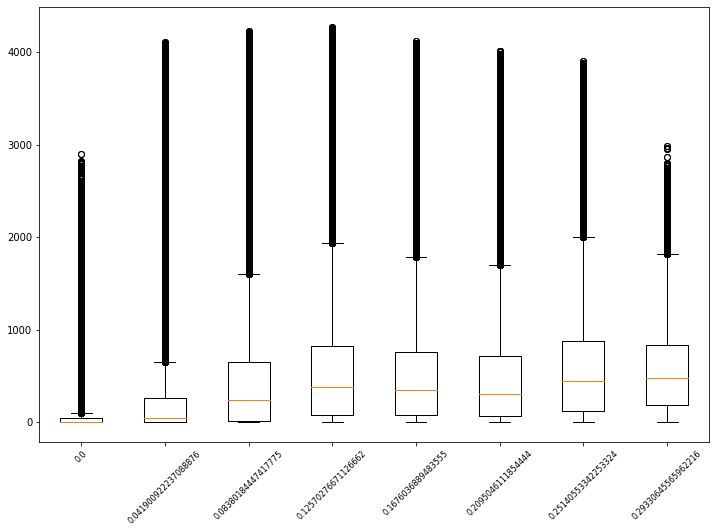


###########

Lags per area: 16



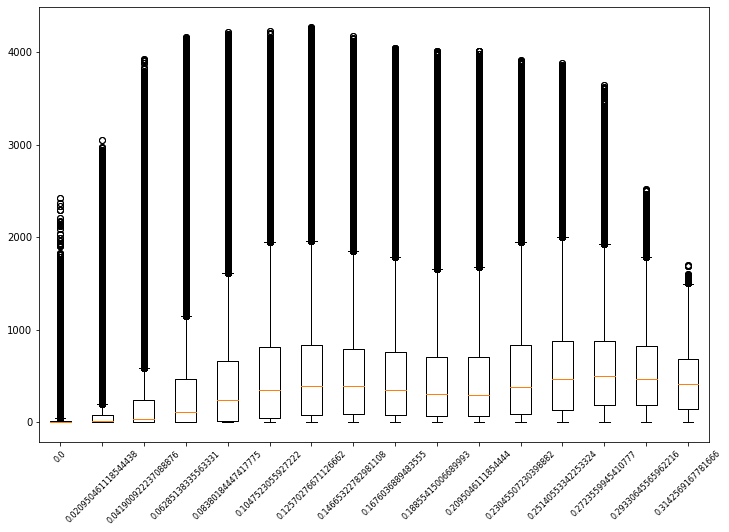


###########

Lags per area: 32



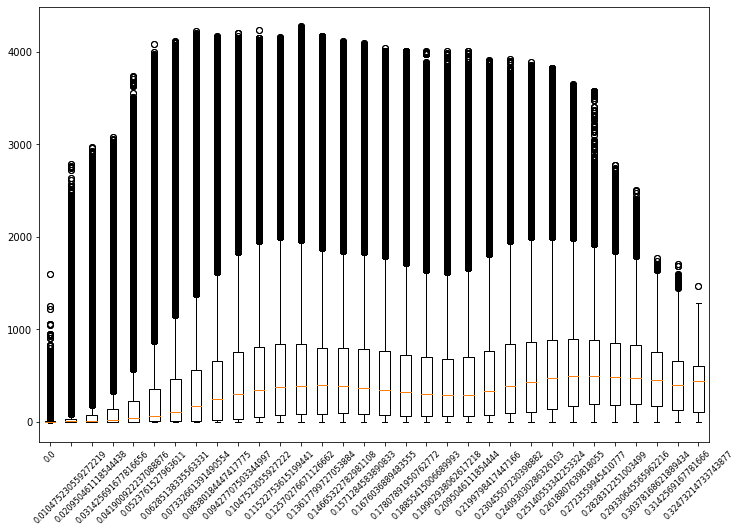


###########



In [6]:
for idx, lag in enumerate(number_of_lags):
    print(f'Lags per area: {lag}')
    print('')
    var_cloud = variogram_clouds[idx]
    show_variogram_cloud(var_cloud, figsize=(12, 8))
    
    print('\n###########\n')

### Clarification:

Boxplots of each lag shows halved squared difference (semivariance) between all points grouped for specific lag. The box extends from the lower to upper quartile values of the data, with a line at the median. The whiskers extend from the box to show the range of the data. Flier points are those past the end of the whiskers. As you may observed we have multiple outliers in a dataset, especially for short- and medium-range semivariance values. This may indicate that dataset should be transformed before analysis. Other interesting fact is that from 8 lags we are able to see specific pattern at a distance 0.18. Variogram is not constant and there is one valley in it.

Why do we plot those boxplots?

1. To check outliers in a data.
2. To check if each distance is well represented by specific number of measurements. This is extremely important at a short-distance scale.
3. To gain initial idea how semivariogram may be look like.

For point 3.: we can check experimental semivariogram and compare it with those boxplots here. We will do it for 16 lags.

In [7]:
search_radius = step_sizes[2]
max_range = maximum_range

exp_semivar = calculate_semivariance(data=dem, step_size=search_radius, max_range=max_range)

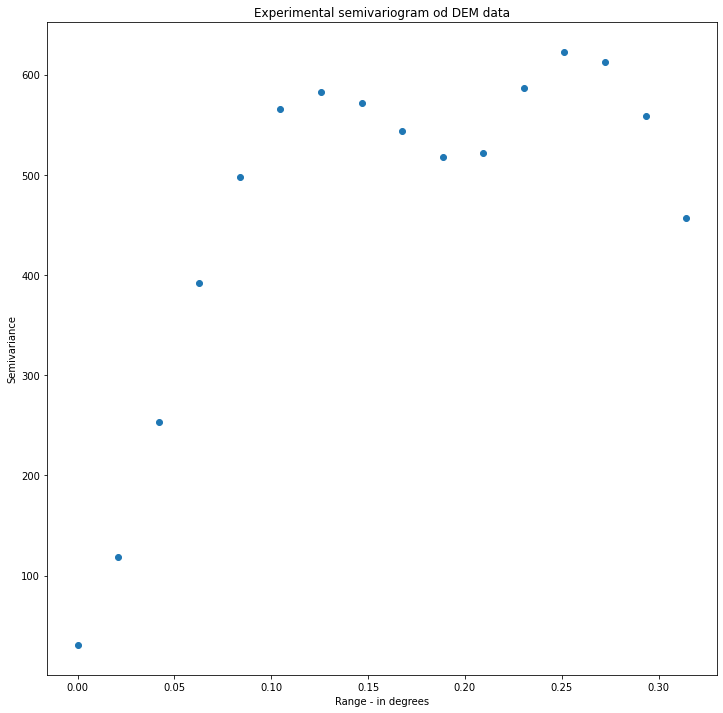

In [9]:
# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1], 'o')
plt.title('Experimental semivariogram od DEM data')
plt.xlabel('Range - in degrees')
plt.ylabel('Semivariance')
plt.show()

### Clarification:

As you may noticed experimental semivariogram has drop of semivariance at 0.2 degree range, which is very close to the drop of variogram point cloud.

## 3) Detect and remove outliers

With idea how Variogram Point Cloud works we can detect and "remove" outliers from our dataset. We use for it other dataset which represents the breast cancer rates in counties of Northeastern part of the U.S. Each county will be transformed into its centroid. Those centroids are not evenly spaced and we can expect that for some number of steps dataset may be modeled incorrectly.

In [10]:
# Read and prepare data

areal_data_file = '../sample_data/areal_data/cancer_data.shp'
areal_id_column_name = 'FIPS'
areal_val_column_name = 'rate'

areal_data = prepare_areal_shapefile(areal_data_file,
                                     id_column_name=areal_id_column_name,
                                     value_column_name=areal_val_column_name)

In [11]:
areal_centroids = areal_data[:, -3:]

In [12]:
# Create analysis parameters

# Check max distance between points

distances = calc_point_to_point_distance(areal_centroids[:, :-1])
maximum_range = np.max(distances)

number_of_lags = [4, 8, 16, 32]
step_sizes = [maximum_range / x for x in number_of_lags]

variogram_clouds = []

for step_size in step_sizes:
    variogram_cloud = build_variogram_point_cloud(areal_centroids, step_size, maximum_range)
    variogram_clouds.append(variogram_cloud)

In [13]:
for idx, lag in enumerate(number_of_lags):
    print(f'Lags per area: {lag}')
    print('')
    var_cloud = variogram_clouds[idx]
    for jdx, cloud in enumerate(var_cloud.keys()):
        l = len(var_cloud[cloud])
        print(f'Lag {cloud} has {l} points.')
    
    print('\n###########\n')

Lags per area: 4

Lag 0.0 has 6893 points.
Lag 301214.2660116966 has 26756 points.
Lag 602428.5320233932 has 11382 points.
Lag 903642.7980350899 has 1962 points.

###########

Lags per area: 8

Lag 0.0 has 2153 points.
Lag 150607.1330058483 has 11272 points.
Lag 301214.2660116966 has 14320 points.
Lag 451821.3990175449 has 10398 points.
Lag 602428.5320233932 has 5324 points.
Lag 753035.6650292415 has 2544 points.
Lag 903642.7980350899 has 822 points.
Lag 1054249.931040938 has 236 points.

###########

Lags per area: 16

Lag 0.0 has 577 points.
Lag 75303.56650292415 has 3670 points.
Lag 150607.1330058483 has 5760 points.
Lag 225910.69950877246 has 7052 points.
Lag 301214.2660116966 has 7268 points.
Lag 376517.83251462074 has 6482 points.
Lag 451821.3990175449 has 5298 points.
Lag 527124.965520469 has 3738 points.
Lag 602428.5320233932 has 2632 points.
Lag 677732.0985263174 has 1854 points.
Lag 753035.6650292415 has 1250 points.
Lag 828339.2315321657 has 728 points.
Lag 903642.7980350899

Lags per area: 4



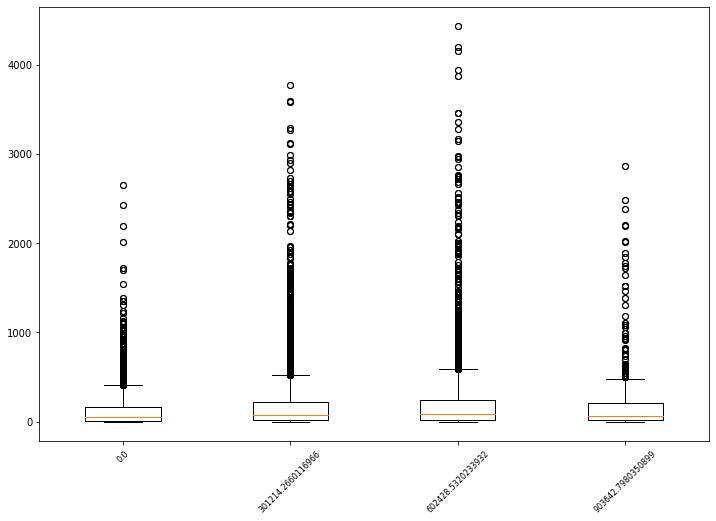


###########

Lags per area: 8



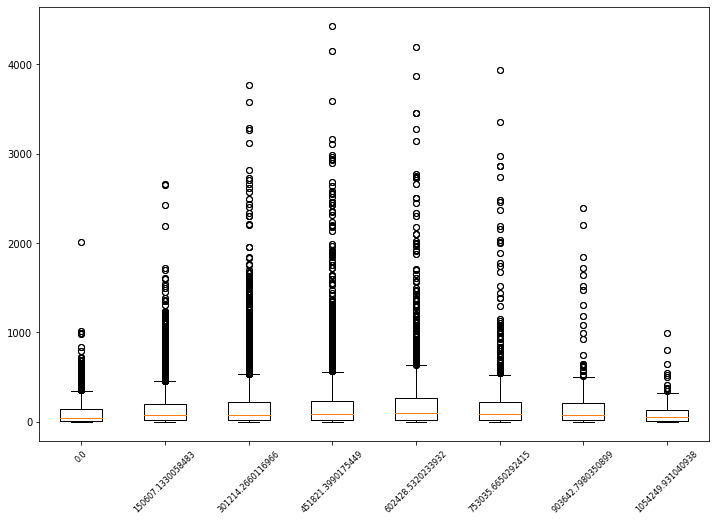


###########

Lags per area: 16



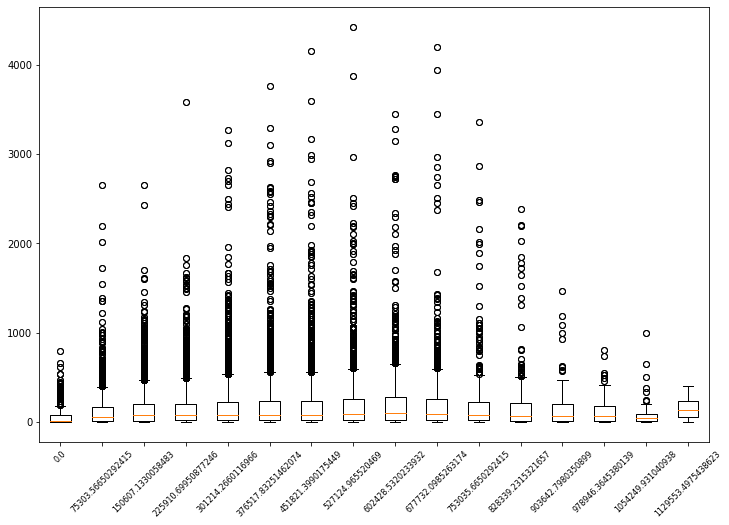


###########

Lags per area: 32



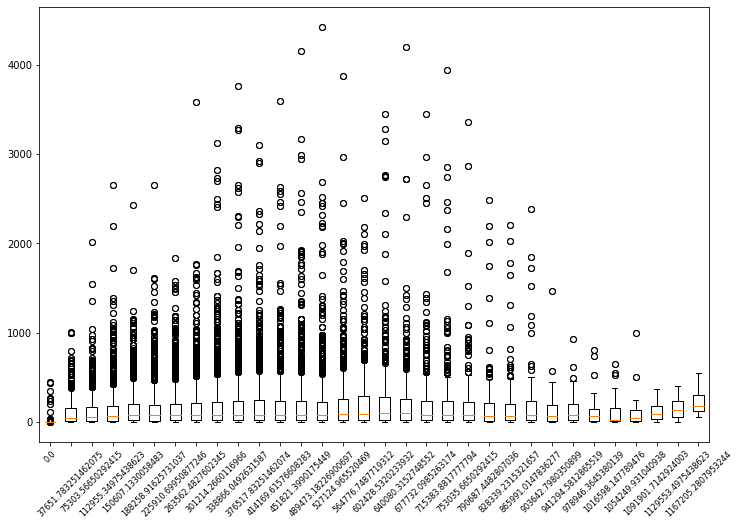


###########



In [14]:
for idx, lag in enumerate(number_of_lags):
    print(f'Lags per area: {lag}')
    print('')
    var_cloud = variogram_clouds[idx]
    show_variogram_cloud(var_cloud, figsize=(12, 8))
    
    print('\n###########\n')

### Clarification

1. There are some outliers in a dataset! To get rid of them we will remove all values which are further away from the mean than 2 standard deviations (for each lag).

In [15]:
cloud_without_outliers = remove_outliers(variogram_clouds[2])

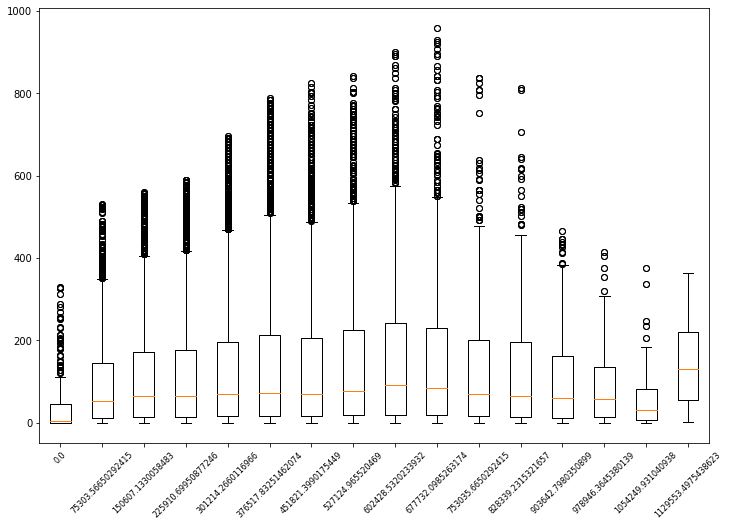

In [16]:
show_variogram_cloud(cloud_without_outliers, figsize=(12, 8))

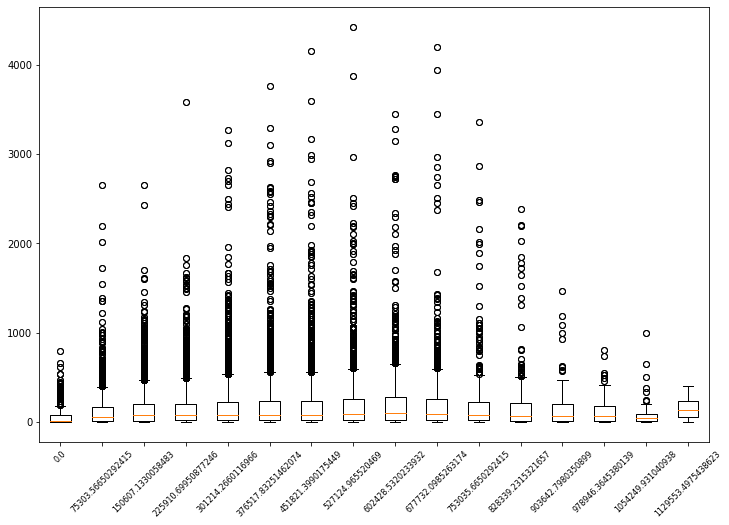

In [17]:
show_variogram_cloud(variogram_clouds[2], figsize=(12, 8))

### Clarification:

Compare y axis of two figures above. Upper figure is cleaned from outliers and lower has those values. Maximum on y axis for the upper is 1000, for the lower is 5000. Experimental semivariogram smooths outliers from initial dataset and you may compare y axis of experimental semivariogram with both variogram clouds to see it.

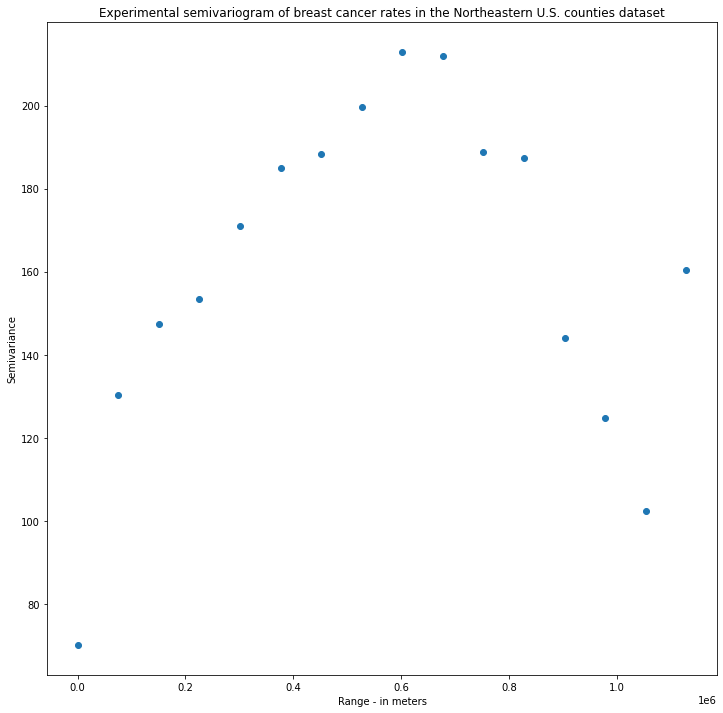

In [18]:
# Experimental semivariogram

search_radius = step_sizes[1]
max_range = maximum_range

exp_semivar = calculate_semivariance(data=areal_centroids, step_size=step_sizes[2], max_range=maximum_range)

# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(exp_semivar[:, 0], exp_semivar[:, 1], 'o')
plt.title('Experimental semivariogram of breast cancer rates in the Northeastern U.S. counties dataset')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

## 4) Calculate experimental semivariogram from point cloud.

You may calculate semivariogram directly, like in the cell above, or from the point cloud. Latter is useful when you perform outliers detection and you remove some of them. Let's check it for our dataset without outliers.

In [19]:
experimental_semivariogram_from_pt_cloud = calc_semivariance_from_pt_cloud(cloud_without_outliers)

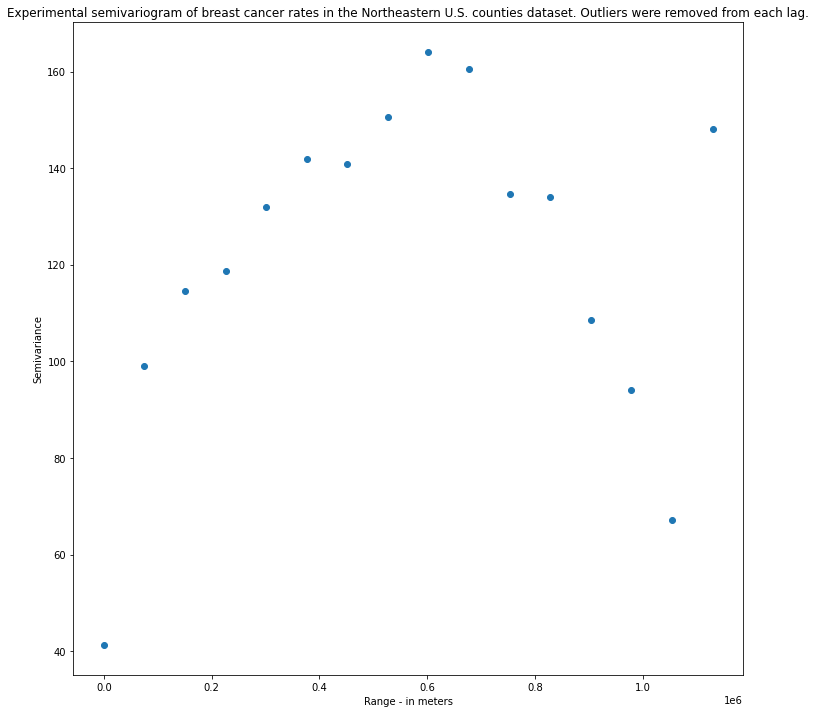

In [21]:
# Plot experimental semivariogram

plt.figure(figsize=(12, 12))
plt.plot(experimental_semivariogram_from_pt_cloud[:, 0], experimental_semivariogram_from_pt_cloud[:, 1], 'o')
plt.title('Experimental semivariogram of breast cancer rates in the Northeastern U.S. counties dataset. Outliers were removed from each lag.')
plt.xlabel('Range - in meters')
plt.ylabel('Semivariance')
plt.show()

As you may noticed, shape of the semivariogram is preserved but values of semivariance are much smaller for the data without outliers.

---